# Notebook Synopsis:

Analyze data to determine how much images can be cropped
- Potentially drop slices with no useful information  
- Potentially remove outer layers of pixels with no useful information

In [2]:
import utils.hgg_utils as hu
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline

### Determine how many slices do not provide any useful information

If the total sum of all values in a slice is 0, the entire slice could be dropped to save space. This would be any
slice that is completely black (first several and last several from every brain volume).

In [3]:
# Grab all of the paths to patient brain volumes
patients = hu.get_each_hgg_folder()
len(patients)

259

#### Using single patient as example...
The shape of the multimodal tensor is [240, 240, 155, 4] (pixel height, pixel width, slice id, modality).

In [4]:
example = hu.get_a_multimodal_tensor(patients[0])

The first slice should sum up to 0 and a slice somewhere in the middle should sum to be greater than 0.

In [37]:
print("Sum of all pixel values across all modalities at slice 0: ", np.sum(example[:, :, 0, :]))
print("Sum of all pixel values across all modalities at slice 80: ", np.sum(example[:, :, 80, :]))

Sum of all pixel values across all modalities at slice 0:  0.0
Sum of all pixel values across all modalities at slice 80:  32235912.0


#### Now across all slices

In [39]:
total_slice_pixel_value = []
for i in range(155):
    total_slice_pixel_value.append(np.sum(example[:, :, i, :]))
    
print(len(total_slice_pixel_value))
print(total_slice_pixel_value)

155
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 439320.0, 3090468.0, 3725616.0, 4195588.0, 4520144.0, 4895868.0, 5244224.0, 5620248.0, 5980032.0, 6339011.0, 6669441.0, 6976719.0, 7245903.0, 7515071.0, 7759279.0, 7988900.0, 8316932.0, 8605128.0, 9239795.0, 9726985.0, 10284045.0, 10776341.0, 11236091.0, 11780340.0, 12599178.0, 13103014.0, 13579158.0, 14051397.0, 14672825.0, 15337857.0, 16232483.0, 16918470.0, 17903604.0, 18688408.0, 19546700.0, 20205672.0, 20879156.0, 21374996.0, 21948412.0, 22465670.0, 22980534.0, 23388080.0, 23843582.0, 24732328.0, 25531426.0, 26778540.0, 27479474.0, 28237028.0, 29080988.0, 29575008.0, 29940456.0, 30357416.0, 30651328.0, 31042434.0, 31471904.0, 31933734.0, 32355670.0, 32626676.0, 32850444.0, 32939470.0, 33046396.0, 33025268.0, 33028520.0, 33013944.0, 33040024.0, 32941154.0, 32854556.0, 32691524.0, 32556662.0, 32423146.0, 32235912.0, 31950444.0, 31627508.0, 31356262.0, 31143150.0, 30912228.0, 30694020.0, 30470374.0, 30196132.0, 29895172.0, 295035

##### Graph for visualization

<function matplotlib.pyplot.show(*args, **kw)>

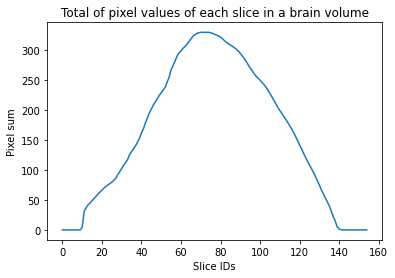

In [52]:
x = np.linspace(0, 154, 155)
# Dividing values by 100,000 for easier visual
y = np.array(total_slice_pixel_value)/100000

plt.plot(x, y)
plt.title('Total of pixel values of each slice in a brain volume')
plt.xlabel('Slice IDs')
plt.ylabel('Pixel sum (in 100ks)')
plt.show


#### It appears that roughly the first 10 and last 15 slices are completely black.

In [54]:
total_slice_pixel_value[:12]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 439320.0, 3090468.0]

In [55]:
total_slice_pixel_value[140:]

[163337.0,
 24796.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

First 10 and last 13 to be exact. Dropping 23 slices would leave us with 132 slices per a volume.
Which is about a 15% reduction in size. 

#### Next, calculate across all patient volumes to see if it holds true...


In [56]:
# Skipping patient at index 0 because we already have those values
# Adding values onto total_slice_pixel_values in their corresponding spots
for i in range(1, len(patients)):
    brain_volume = hu.get_a_multimodal_tensor(patients[i])
    for k in range(155):
        total_slice_pixel_value[k] =+ np.sum(brain_volume[:, :, k, :])
    

Honestly.... Taking longer than I expected 

Two full minutes later :D

In [57]:
total_slice_pixel_value[:12]

[373323.0,
 2559798.0,
 7491794.0,
 11085123.0,
 14092696.0,
 16619699.0,
 18433624.0,
 19752776.0,
 20686556.0,
 21630214.0,
 22728508.0,
 23718316.0]

In [58]:
total_slice_pixel_value[140:]

[6319280.0,
 4078400.0,
 2207488.0,
 768085.0,
 105431.0,
 138.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

<function matplotlib.pyplot.show(*args, **kw)>

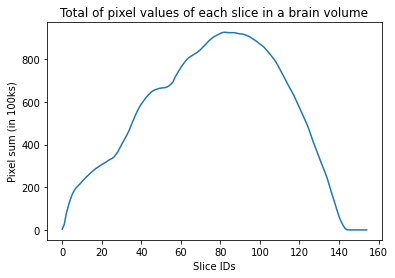

In [61]:
x = np.linspace(0, 154, 155)
# Dividing values by 100,000 for easier visual
y = np.array(total_slice_pixel_value)/100000

plt.plot(x, y)
plt.title('Total of pixel values of each slice in a brain volume')
plt.xlabel('Slice IDs')
plt.ylabel('Pixel sum (in 100ks)')
plt.show

So... According to the chart there are only 8 slices across all modalities and all patients that can
be completely dropped without losing any data at all. 

This is still a 5% reduction in size and 
brings up the question of how useful the slices that fall below 100k total pixel value (across all patients and slices) 
really are???

## How many outer layers of pixels could be cropped without losing useful information?

To determine this I'll do something similar to what I did above. I'll take the sum of 
all values in rows/cols of the image slices, where that is 0 we can remove it. 

A couple things to keep in mind:
- Images should remain a square
- Total width and height of image will need to work with down sampling.
Example 1: 240x240 -> 120x120 -> 60x60 -> 30x30 works well.
Example 2: 230x230 -> 115x115 -> ... At this point we would have padding issues.

#### Starting with just a single brain volume to example

Only going to check the first and last 30 rows/cols.

In [5]:
rows_from_top = []
rows_from_bottom = []
cols_from_left = []
cols_from_right = []

for i in range(30):
    # Sum of row i in all slices and modalities
    rows_from_top.append(np.sum(example[i, :, :, :]))
    # Sum of col i in all slices and modalities
    cols_from_left.append(np.sum(example[:, i, :, :]))
    
for j in range(-1, -31, -1):
    # Sum of row j in all slices and modalities
    # Starts from the bottom i.e. sum of bottom row of image 
    # will be in rows_from_bottom[0]
    rows_from_bottom.append((np.sum(example[j, :, :, :])))
    # Sum of col j in all slices and modalities
    cols_from_right.append(np.sum(example[:, j, :, :]))

#### Let's look at the results

<function matplotlib.pyplot.show(*args, **kw)>

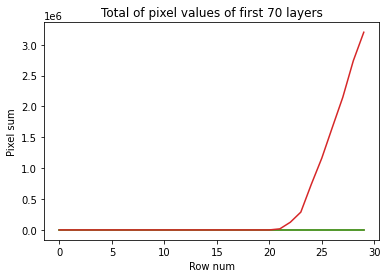

In [6]:
x = np.linspace(0, 29, 30)
y = rows_from_top

plt.plot(x, y)
plt.title('Total of pixel values of first 70 rows')
plt.xlabel('Row num')
plt.ylabel('Pixel sum')
plt.show

y = rows_from_bottom

plt.plot(x, y)
plt.title('Total of pixel values of first 70 rows')
plt.xlabel('Row num')
plt.ylabel('Pixel sum')
plt.show

y = cols_from_left

plt.plot(x, y)
plt.title('Total of pixel values of first 70 cols')
plt.xlabel('Row num')
plt.ylabel('Pixel sum')
plt.show

y = cols_from_right

plt.plot(x, y)
plt.title('Total of pixel values of first 70 layers')
plt.xlabel('Row num')
plt.ylabel('Pixel sum')
plt.show

### The chart shows us that we start seeing values around 22 layers in.

Still need to check the rest of the data but if we cropped the outside 20 layers of pixels 
the images would be 200x200.

Down sampling would be 200x200 -> 100x100 -> 50x50 -> 25x25 which would work. Let's check the rest of the data.


In [7]:
# Skipping patient at index 0 because we already have those values
# Adding values onto corresponding spots in the arrays that we already have
# Only going to do the first 30 layers this time.
for i in range(1, len(patients)):
    brain_volume = hu.get_a_multimodal_tensor(patients[i])
    for k in range(30):
        rows_from_top[k] += np.sum(brain_volume[k, :, :, :])
        cols_from_left[k] += np.sum(brain_volume[:, k, :, :])
    for j in range(-1, -31, -1):
        rows_from_bottom[-j - 1] += np.sum(brain_volume[j, :, :, :])
        cols_from_right[-j - 1] += np.sum(brain_volume[:, j, :, :])

<function matplotlib.pyplot.show(*args, **kw)>

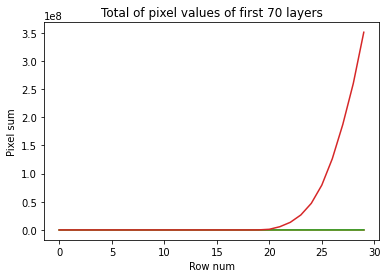

In [8]:
x = np.linspace(0, 29, 30)
y = rows_from_top

plt.plot(x, y)
plt.title('Total of pixel values of first 70 rows')
plt.xlabel('Row num')
plt.ylabel('Pixel sum')
plt.show

y = rows_from_bottom

plt.plot(x, y)
plt.title('Total of pixel values of first 70 rows')
plt.xlabel('Row num')
plt.ylabel('Pixel sum')
plt.show

y = cols_from_left

plt.plot(x, y)
plt.title('Total of pixel values of first 70 cols')
plt.xlabel('Row num')
plt.ylabel('Pixel sum')
plt.show

y = cols_from_right

plt.plot(x, y)
plt.title('Total of pixel values of first 70 layers')
plt.xlabel('Row num')
plt.ylabel('Pixel sum')
plt.show


### The chart shows that we start seeing values in about the 20th layer

In [10]:
print(rows_from_top[:20])
print(rows_from_bottom[:20])
print(cols_from_left[:20])
print(cols_from_right[:20])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 70837.0]


19th Layer to be exact. Meaning we can crop out the 18 outer most layers of pixel values without
losing any useful data at all. Removing  18 layers would leave the images as a 204x204 pixels, which is about 
27.75% reduction in size.

If we take a look at the unet diagram from the ordinal paper (https://arxiv.org/abs/1505.04597), the red arrows denote 
down sampling via max pooling. They pool using 2x2 squares which cut the image in half at each layer. 

![](examples/unet_model.png)

If we consider our max pooling on an image that is size 204x204 we would have:

204x204 -> 102x102 -> 51x51 -> then we would have to use some kind of padding to scale down further.

If we decided to only crop out 16 layers the down sampling would go as:

208x208 -> 104x104 -> 52x52 -> 26x26 -> 13x13

Here we can scale down further without extra work of having to figure out handling padding. Doing this would still 
give us a 24.88% reduction in the size of our images. 